In [ ]:
## ONLY RUN IF NEEDED FOR SETUP
## %pip install obspy
## %pip install geopy
## %pip install scikit-learn
## %pip install statsmodels
## %pip install pandas
## %pip install folium
## %pip install geopandas
## %pip install shapely
## %pip install geodatasets
## %pip install graphviz

In [3]:
from obspy.clients.fdsn import Client
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz
import graphviz
import warnings
import folium
from folium.plugins import HeatMap
from IPython.display import display
import geopandas as gpd
import geodatasets
from shapely.geometry import Point
import sys


def get_geolocation(city="Challis, ID"):
    """Fetch the latitude and longitude of a city."""
    geolocator = Nominatim(user_agent="TomPEQProject")
    try:
        loc = geolocator.geocode(city)
        if loc:
            return loc.latitude, loc.longitude
        else:
            print(f"City {city} not found.")
            return None
    except Exception as e:
        print(f"Error fetching geolocation for {city}: {e}")
        return None

def get_earthquake_data(client="USGS", city="Challis, ID", maxradius=1, starttime="1900-10-01", 
                        endtime="2024-10-11", minmagnitude=2.5,  maxmagnitude=6):
    """Fetch earthquake events around a city."""
    lat, lon = get_geolocation(city)
    if lat is None or lon is None:
        return None

    try:
        catalog = client.get_events(starttime=starttime, 
                                endtime=endtime, 
                                minmagnitude=minmagnitude,
                                maxmagnitude=maxmagnitude,
                                eventtype="earthquake",
                                latitude=lat,
                                longitude=lon,
                                maxradius=maxradius
                                )
        return catalog
    except Exception as e:
        print(f"Error fetching events: {e}")
        return None
    
def process_earthquake_data(catalog):
    """Process the fetched earthquake events and extract location information."""
    locs = []
    if catalog:
        for event in catalog:
            temp = event.origins[0]
            if temp.longitude is not None and temp.latitude is not None and temp.depth is not None:
                location = [temp.longitude, temp.latitude, temp.depth, temp.time, event.magnitudes[0].mag]  
                locs.append(location)
                #print(f"Event Time: {temp.time}, Magnitude: {event.magnitudes[0].mag}")
                #print(location)
        max_depth = max(locs, key=lambda x: x[2])[2]

        locs = np.array(locs)
        
        return locs, max_depth
    else:
        return None
    
def normalize_depth(locs):
    """Normalize the depth values."""
    scaler = MinMaxScaler()
    locs[:, 2] = -scaler.fit_transform(locs[:, 2].reshape(-1, 1)).flatten()
    return locs

def split_by_date(locs, num_splits=6):
    """Splits the data into equals sections"""
    splits = np.array_split(locs, num_splits)
    return splits

def show_progression(city="Challis, ID", maxradius=1, elev=0, azim=90):
    """Create graphic of a seismic datasets progression through time."""
    client = Client("USGS")
    catalog = get_earthquake_data(client=client, city=city, maxradius=maxradius)
    if catalog:
        locs, max_depth = process_earthquake_data(catalog)
        locs = normalize_depth(locs)
        locs = locs[locs[:, 3].argsort()]
        split_locs = split_by_date(locs,6)
        
        lat, lon = get_geolocation(city=city)

        
        # Create a 3D plot for each split
        for i, split in enumerate(split_locs):
            
            
            start_time = split[0, 3]
            end_time = split[-1, 3]
            
            # Get Time range of each split
            start_time_str = start_time.strftime('%Y-%m-%d %H:%M:%S')
            end_time_str = end_time.strftime('%Y-%m-%d %H:%M:%S')
            time_range_str = f"{start_time_str} to {end_time_str}"
            
            fig = plt.figure(figsize=(8, 8))
            ax = fig.add_subplot(111, projection='3d')
            scatter = ax.scatter(split[:, 0], split[:, 1], split[:, 2] * max_depth, 
                                 label=f'Events', marker='o')
        
            ax.scatter(lon, lat, 0, c='black', marker='*', s=200, label='City')

            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')
            ax.set_zlabel('Depth (km)')

            ax.set_title(f"""Earthquake Locations for {city} (Latitude, Longitude, Depth) \nbetween {time_range_str}""")
            ax.legend()

            ax.view_init(elev=elev, azim=azim)

            plt.show()
    else:
        return None
    
def perform_clustering(locs):
    """Perform hierarchical clustering on earthquake locations."""
    linked = linkage(locs, method='ward')
    return linked

def perform_labeling(linked, k):
    """Creates and labels each cluster for graphing."""
    labels = fcluster(linked, k, criterion='maxclust')
    return labels

def plot_dendrogram(linked):
    """Plot the hierarchical clustering dendrogram."""
    plt.figure(figsize=(10, 7))
    dendro = dendrogram(linked)
    color_dict = {color for color in dendro['color_list']}
    num_colors = len(color_dict)
    
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Event index')
    plt.ylabel('Distance')
    plt.show()
    
    return num_colors - 1

def plot_3d_clusters(locs, labels, city, max_depth, elev, azim):
    """Plot the 3D scatter plot of earthquake locations and clusters."""
    fig = plt.figure(figsize=(10,8))
    lat, lon = get_geolocation(city=city)

    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(locs[:, 0], locs[:, 1], locs[:, 2]*max_depth, c=labels, cmap='jet', marker='o', label='Events')
    ax.scatter(lon, lat, 0, c='black', marker='*', s=200, label='City')

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Depth (km)')

    ax.set_title(f'Hierarchical Clustering of Earthquake Locations for {city} (Latitude, Longitude, Depth) ')
    ax.legend()

    ax.view_init(elev=elev, azim=azim)

    plt.show()

def seismic_kmeans_clusters(locs, city, max_depth, k=3, elev=0, azim=90):
    """Plot the k-means clustering results."""
    
    features = locs[:, :3]  # Longitude, Latitude, Depth
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    
    # Retrieve cluster labels and centroids
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    
    fig = plt.figure(figsize=(10, 8))
    lat, lon = get_geolocation(city=city)

    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(locs[:, 0], locs[:, 1], locs[:, 2] * max_depth, c=labels, cmap='jet', marker='o', label='Events')
    ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2] * max_depth, c='green', marker='x', s=100, label='Centroids')
    ax.scatter(lon, lat, 0, c='black', marker='*', s=200, label='City')

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Depth (km)')
    ax.set_title(f'K-Means Clustering of Earthquake Locations for {city}')
    ax.legend()

    ax.view_init(elev=elev, azim=azim)
    plt.show()

def predict_Seismic_RF(city, locs, duration=30, freq='YE'):
    """Predict the number of earthquake events in a future/Past time span using Random Forest."""
    locs = locs[locs[:, 3].argsort()]
    
    # Convert times to datetime format
    event_times =  [time.datetime for time in locs[:, 3]]
    
    locs_df = pd.DataFrame({
        'latitude': locs[:, 0],
        'longitude': locs[:, 1],
        'depth': locs[:, 2],
        'event_time': event_times
    })
    locs_df.set_index('event_time', inplace=True)
    
    # Resample data to match the frequency
    event_counts = locs_df.resample(freq).size()
    aggregated_features = locs_df.resample(freq).mean()
    
    event_counts_df = pd.DataFrame(event_counts, columns=['event_count'])
    event_counts_df['latitude'] = aggregated_features['latitude']
    event_counts_df['longitude'] = aggregated_features['longitude']
    event_counts_df['depth'] = aggregated_features['depth']
    event_counts_df['year'] = event_counts_df.index.year
    event_counts_df['month'] = event_counts_df.index.month
    event_counts_df['day'] = event_counts_df.index.day
    
    X = event_counts_df[['year', 'month', 'day', 'latitude', 'longitude', 'depth']]
    y = event_counts_df['event_count']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    
    future_dates = pd.date_range(event_counts_df.index[-1], periods=duration+1, freq=freq)[1:]
    future_features = pd.DataFrame({
        'year': future_dates.year,
        'month': future_dates.month,
        'day': future_dates.day,
        'latitude': X['latitude'].mean(),  
        'longitude': X['longitude'].mean(),  
        'depth': X['depth'].mean()  
    })
    
    forecast = rf_model.predict(future_features)
    

    past_dates = pd.date_range(event_counts_df.index[0] - pd.DateOffset(years=duration), periods=duration+1, freq=freq)[1:]
    backcast_features = pd.DataFrame({
        'year': past_dates.year,
        'month': past_dates.month,
        'day': past_dates.day,
        'latitude': X['latitude'].mean(),  
        'longitude': X['longitude'].mean(),  
        'depth': X['depth'].mean()  
    })
    
    backcast = rf_model.predict(backcast_features)
    
    
    plt.figure(figsize=(10, 8))
    plt.plot(event_counts_df.index, event_counts_df['event_count'], label='Historical Data', color='blue')
    plt.plot(future_dates, forecast, label='Forecasted Data', color='red')
    plt.plot(past_dates, backcast, label='Backcasted Data', color='green')
    plt.title(f'Event Count Forecast for {city} using RF')
    plt.xlabel('Date')
    plt.ylabel('Event Count')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # For Readability
    print(f"\nPredicted Number of Events for {city} in the prior {duration} {freq}s:")
    for date, count in zip(past_dates, backcast):
        print(f"{date.strftime('%Y-%m-%d')}    {count:.2f}")
    print(f"Predicted Number of Events for {city} in the next {duration} {freq}s:")
    for date, count in zip(future_dates, forecast):
        print(f"{date.strftime('%Y-%m-%d')}    {count:.2f}")


def predict_Seismic_ARIMA(city, locs, duration=30, freq='YE'):
    """Predict the number of earthquake events in a future time span using ARIMA."""
    
    locs = locs[locs[:, 3].argsort()]
    
    event_times = [time.datetime for time in locs[:, 3]] # Convert to datetime
    
    event_counts = pd.Series(1, index=pd.to_datetime(event_times)).resample(freq).count() # Count number of events per freq
    
    event_counts_reversed = event_counts[::-1] # For Backcasting
    
    warnings.filterwarnings("ignore") # Warning caused by performing back prediction and non-stationary
    model = ARIMA(event_counts, order=(5, 1, 0)) # Create ARIMA model
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=duration) # Create forecast
    future_dates = pd.date_range(event_counts.index[-1], periods=duration+1, freq=freq)[1:] # Starting at end of historical data
    
    model = ARIMA(event_counts_reversed, order=(5, 1, 0)) # Create ARIMA model
    model_fit = model.fit()
    backcast = model_fit.forecast(steps=duration) # Create forecast 
    past_dates = pd.date_range(event_counts.index[0] - pd.DateOffset(years=duration), periods=duration+1, freq=freq)[1:]
    warnings.filterwarnings("default")
    
    forecast[forecast < 0] = 0
    backcast[backcast < 0] = 0
    
    plt.figure(figsize=(10, 8))
    plt.plot(event_counts.index, event_counts, label='Historical Data', color='blue')  # Historical data plot
    plt.plot(future_dates, forecast, label='Forecasted Data', color='red')  # Forecast data plot
    plt.plot(past_dates, backcast, label='Backcasted Data', color='green')
    plt.title(f'Event Count Forecast for {city} using ARIMA')
    plt.xlabel('Date')
    plt.ylabel('Event Count')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # For Readability
    print(f"\nPredicted Number of Events for {city} in the prior {duration} {freq}s:")
    for date, count in zip(past_dates, backcast):
        print(f"{date.strftime('%Y-%m-%d')}    {count:.2f}")
    print(f"Predicted Number of Events {city} for the next {duration} {freq}s:\n{forecast}")
    
def Seismic_DT_Analysis(city, locs, max_depth=10000, min_samples_leaf=10, max_tree_depth=6):
    """Create Decision tree Classifier to find interesting features about locs data"""

    event_times = [time.datetime for time in locs[:, 3]]
    

    locs_df = pd.DataFrame({
        'latitude': locs[:, 0],
        'longitude': locs[:, 1],
        'depth': locs[:, 2]*max_depth,
        'event_time': event_times,
        'magnitude': locs[:, 4]
    })
    

    locs_df['year'] = locs_df['event_time'].dt.year
    locs_df['month'] = locs_df['event_time'].dt.month
    locs_df['day'] = locs_df['event_time'].dt.day
    

    locs_df.set_index('event_time', inplace=True)
    
    X = locs_df[['year', 'month', 'day', 'latitude', 'longitude', 'depth']]
    y = locs_df['magnitude']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    DT = DecisionTreeRegressor(max_depth=max_tree_depth, min_samples_leaf=min_samples_leaf, random_state=42)
    DT.fit(X_train, y_train)
    
    feature_names = ['year', 'month', 'day', 'latitude', 'longitude', 'depth']

    dot_data = export_graphviz(DT, out_file=None, 
                               feature_names=feature_names,  
                               class_names=np.unique(y).astype(str),
                               filled=True, rounded=True,  
                               special_characters=True)

    graph = graphviz.Source(dot_data)
    
    output_file_path = f"./Images/DT_Regressor_{city}"
    
    graph.render(output_file_path, format="png")
    
    
    display(graph)

def create_heatmap(locs, city="Challis, ID", maxradius=1):
    """Creates a heat map of the location."""
    
    lat, lon = get_geolocation(city)
    if lat is None or lon is None:
        print("Could not fetch city coordinates for heatmap.")
        return None
    
    m = folium.Map(location=[lat, lon], zoom_start=8)
    
    heat_data = [[loc[1], loc[0]] for loc in locs]
    HeatMap(heat_data, radius=10).add_to(m)
    
    folium.Circle(
        location=(lat, lon),
        radius=maxradius * 1000 * 111,  # Convert degrees to approximate meters
        color='red',
        popup=f"Search Area: {maxradius}° (~{maxradius*111:.2f} km)"
    ).add_to(m)
    
    display(m)

def create_heatmap_topo(locs, city="Challis, ID", maxradius=1):
    """Creates a heat map of the location."""
    
    lat, lon = get_geolocation(city)
    if lat is None or lon is None:
        print("Could not fetch city coordinates for heatmap.")
        return None
    
    m = folium.Map(location=[lat, lon], zoom_start=8)
    folium.TileLayer('OpenTopoMap',  attr='Map tiles by OpenTopoMap').add_to(m) # Add Topography
    
    heat_data = [[loc[1], loc[0]] for loc in locs]
    HeatMap(heat_data, radius=10).add_to(m)
    
    folium.Circle(
        location=(lat, lon),
        radius=maxradius * 1000 * 111,  # Convert degrees to approximate meters
        color='red',
        popup=f"Search Area: {maxradius}° (~{maxradius*111:.2f} km)"
    ).add_to(m)
    
    display(m)

def choropleth_scatterplot(locs, state_name="aaaa", country_name="aaaa", city="Challis, ID"):
    """ Create a choropleth scatter plot map for earthquake data."""

    # Load Data for choropleth    
    if state_name != "aaaa":
        world = gpd.read_file("ne_110m_admin_1_states_provinces\\ne_110m_admin_1_states_provinces.shp")
        location = world[world['name'] == state_name]
    elif country_name != "aaaa":
        world = gpd.read_file("ne_110m_admin_0_countries\\ne_110m_admin_0_countries.shp")
        location = world[world['NAME'] == country_name]
    else:
        world = gpd.read_file("ne_110m_admin_0_countries\\ne_110m_admin_0_countries.shp")
        location = world[world['NAME'] == 'United States of America']
    
    lat, lon = get_geolocation(city)
    if lat is None or lon is None:
        print(f"Could not fetch geolocation for {city}.")
        return None
    
    earthquake_gdf = gpd.GeoDataFrame({
    'Longitude': locs[:, 0],
    'Latitude': locs[:, 1],
    'Coordinates': [Point(xy) for xy in zip(locs[:, 0], locs[:, 1])]
    })

    earthquake_gdf = gpd.GeoDataFrame(earthquake_gdf, geometry='Coordinates')
    
    bounds = location.geometry.bounds
    minx, miny, maxx, maxy = bounds.iloc[0]
    
    fig, ax = plt.subplots(figsize=(15, 10))
    world.plot(ax=ax, color='lightgray')
    location.plot(ax=ax, color='lightblue')
    scatter = earthquake_gdf.plot(ax=ax, color='red')
    plt.title(f'Chloropleth Map of Seismic Data')
    ax.set_xlim(minx - 2, maxx + 2)  
    ax.set_ylim(miny - 2, maxy + 2)
    
    
    plt.show()

def perform_Seismitc_Analysis(city="Challis, ID", maxradius=1, data_starttime="1900-10-01", 
                              data_endtime="2024-10-11", freq='YE',  elev=0, azim=90,clusters=0, 
                              state_name="aaaa", country_name="aaaa", max_tree_depth=6,
                               min_samples_leaf=10):   
    """Perform full seismic analysis and estimation"""
    
    client = Client("USGS")
    catalog = get_earthquake_data(client=client, city=city, maxradius=maxradius, 
                                  starttime=data_starttime, endtime=data_endtime)
    if catalog:
        locs, max_depth = process_earthquake_data(catalog)
        locs = normalize_depth(locs)
    

    linked = perform_clustering(locs)
    if clusters == 0:
        k = plot_dendrogram(linked)
    else:
        k = clusters
    labels = perform_labeling(linked, k)

    plot_3d_clusters(locs, labels, city=city, max_depth=max_depth, elev=elev, azim=azim)
    seismic_kmeans_clusters(locs, city=city, max_depth=max_depth, k=k, elev=elev, azim=azim)
    choropleth_scatterplot(locs, state_name=state_name, country_name=country_name, city=city)
    create_heatmap(locs, city=city)
    create_heatmap_topo(locs, city=city)
    
    predict_Seismic_RF(city, locs, duration=20, freq=freq)
    predict_Seismic_ARIMA(city, locs, duration=20, freq=freq)
    Seismic_DT_Analysis(city, locs, max_tree_depth=max_tree_depth,  min_samples_leaf=min_samples_leaf)
    labels = fcluster(linked, k, criterion='maxclust')
    return labels

def plot_dendrogram(linked):
    """Plot the hierarchical clustering dendrogram."""
    plt.figure(figsize=(10, 7))
    dendro = dendrogram(linked)
    color_dict = {color for color in dendro['color_list']}
    num_colors = len(color_dict)
    
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Event index')
    plt.ylabel('Distance')
    plt.show()
    
    return num_colors - 1

def plot_3d_clusters(locs, labels, city, max_depth, elev, azim):
    """Plot the 3D scatter plot of earthquake locations and clusters."""
    fig = plt.figure(figsize=(10,8))
    lat, lon = get_geolocation(city=city)

    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(locs[:, 0], locs[:, 1], locs[:, 2]*max_depth, c=labels, cmap='jet', marker='o', label='Events')
    ax.scatter(lon, lat, 0, c='black', marker='*', s=200, label='City')

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Depth (km)')

    ax.set_title(f'Hierarchical Clustering of Earthquake Locations for {city} (Latitude, Longitude, Depth) ')
    ax.legend()

    ax.view_init(elev=elev, azim=azim)

    plt.show()

def seismic_kmeans_clusters(locs, city, max_depth, k=3, elev=0, azim=90):
    """Plot the k-means clustering results."""
    
    features = locs[:, :3]  # Longitude, Latitude, Depth
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    
    # Retrieve cluster labels and centroids
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    
    fig = plt.figure(figsize=(10, 8))
    lat, lon = get_geolocation(city=city)

    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(locs[:, 0], locs[:, 1], locs[:, 2] * max_depth, c=labels, cmap='jet', marker='o', label='Events')
    ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2] * max_depth, c='green', marker='x', s=100, label='Centroids')
    ax.scatter(lon, lat, 0, c='black', marker='*', s=200, label='City')

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Depth (km)')
    ax.set_title(f'K-Means Clustering of Earthquake Locations for {city}')
    ax.legend()

    ax.view_init(elev=elev, azim=azim)
    plt.show()

def predict_Seismic_RF(city, locs, duration=30, freq='YE'):
    """Predict the number of earthquake events in a future/Past time span using Random Forest."""
    locs = locs[locs[:, 3].argsort()]
    
    # Convert times to datetime format
    event_times =  [time.datetime for time in locs[:, 3]]
    
    locs_df = pd.DataFrame({
        'latitude': locs[:, 0],
        'longitude': locs[:, 1],
        'depth': locs[:, 2],
        'event_time': event_times
    })
    locs_df.set_index('event_time', inplace=True)
    
    # Resample data to match the frequency
    event_counts = locs_df.resample(freq).size()
    aggregated_features = locs_df.resample(freq).mean()
    
    event_counts_df = pd.DataFrame(event_counts, columns=['event_count'])
    event_counts_df['latitude'] = aggregated_features['latitude']
    event_counts_df['longitude'] = aggregated_features['longitude']
    event_counts_df['depth'] = aggregated_features['depth']
    event_counts_df['year'] = event_counts_df.index.year
    event_counts_df['month'] = event_counts_df.index.month
    event_counts_df['day'] = event_counts_df.index.day
    
    X = event_counts_df[['year', 'month', 'day', 'latitude', 'longitude', 'depth']]
    y = event_counts_df['event_count']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    
    future_dates = pd.date_range(event_counts_df.index[-1], periods=duration+1, freq=freq)[1:]
    future_features = pd.DataFrame({
        'year': future_dates.year,
        'month': future_dates.month,
        'day': future_dates.day,
        'latitude': X['latitude'].mean(),  
        'longitude': X['longitude'].mean(),  
        'depth': X['depth'].mean()  
    })
    
    forecast = rf_model.predict(future_features)
    

    past_dates = pd.date_range(event_counts_df.index[0] - pd.DateOffset(years=duration), periods=duration+1, freq=freq)[1:]
    backcast_features = pd.DataFrame({
        'year': past_dates.year,
        'month': past_dates.month,
        'day': past_dates.day,
        'latitude': X['latitude'].mean(),  
        'longitude': X['longitude'].mean(),  
        'depth': X['depth'].mean()  
    })
    
    backcast = rf_model.predict(backcast_features)
    
    
    plt.figure(figsize=(10, 8))
    plt.plot(event_counts_df.index, event_counts_df['event_count'], label='Historical Data', color='blue')
    plt.plot(future_dates, forecast, label='Forecasted Data', color='red')
    plt.plot(past_dates, backcast, label='Backcasted Data', color='green')
    plt.title(f'Event Count Forecast for {city} using RF')
    plt.xlabel('Date')
    plt.ylabel('Event Count')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # For Readability
    print(f"\nPredicted Number of Events for {city} in the prior {duration} {freq}s:")
    for date, count in zip(past_dates, backcast):
        print(f"{date.strftime('%Y-%m-%d')}    {count:.2f}")
    print(f"Predicted Number of Events for {city} in the next {duration} {freq}s:")
    for date, count in zip(future_dates, forecast):
        print(f"{date.strftime('%Y-%m-%d')}    {count:.2f}")


def predict_Seismic_ARIMA(city, locs, duration=30, freq='YE'):
    """Predict the number of earthquake events in a future time span using ARIMA."""
    
    locs = locs[locs[:, 3].argsort()]
    
    event_times = [time.datetime for time in locs[:, 3]] # Convert to datetime
    
    event_counts = pd.Series(1, index=pd.to_datetime(event_times)).resample(freq).count() # Count number of events per freq
    
    event_counts_reversed = event_counts[::-1] # For Backcasting
    
    warnings.filterwarnings("ignore") # Warning caused by performing back prediction and non-stationary
    model = ARIMA(event_counts, order=(5, 1, 0)) # Create ARIMA model
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=duration) # Create forecast
    future_dates = pd.date_range(event_counts.index[-1], periods=duration+1, freq=freq)[1:] # Starting at end of historical data
    
    model = ARIMA(event_counts_reversed, order=(5, 1, 0)) # Create ARIMA model
    model_fit = model.fit()
    backcast = model_fit.forecast(steps=duration) # Create forecast 
    past_dates = pd.date_range(event_counts.index[0] - pd.DateOffset(years=duration), periods=duration+1, freq=freq)[1:]
    warnings.filterwarnings("default")
    
    forecast[forecast < 0] = 0
    backcast[backcast < 0] = 0
    
    plt.figure(figsize=(10, 8))
    plt.plot(event_counts.index, event_counts, label='Historical Data', color='blue')  # Historical data plot
    plt.plot(future_dates, forecast, label='Forecasted Data', color='red')  # Forecast data plot
    plt.plot(past_dates, backcast, label='Backcasted Data', color='green')
    plt.title(f'Event Count Forecast for {city} using ARIMA')
    plt.xlabel('Date')
    plt.ylabel('Event Count')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # For Readability
    print(f"\nPredicted Number of Events for {city} in the prior {duration} {freq}s:")
    for date, count in zip(past_dates, backcast):
        print(f"{date.strftime('%Y-%m-%d')}    {count:.2f}")
    print(f"Predicted Number of Events {city} for the next {duration} {freq}s:\n{forecast}")
    
def Seismic_DT_Analysis(city, locs, max_depth=10000, min_samples_leaf=10, max_tree_depth=6):
    """Create Decision tree Classifier to find interesting features about locs data"""

    event_times = [time.datetime for time in locs[:, 3]]
    

    locs_df = pd.DataFrame({
        'latitude': locs[:, 0],
        'longitude': locs[:, 1],
        'depth': locs[:, 2]*max_depth,
        'event_time': event_times,
        'magnitude': locs[:, 4]
    })
    

    locs_df['year'] = locs_df['event_time'].dt.year
    locs_df['month'] = locs_df['event_time'].dt.month
    locs_df['day'] = locs_df['event_time'].dt.day
    

    locs_df.set_index('event_time', inplace=True)
    
    X = locs_df[['year', 'month', 'day', 'latitude', 'longitude', 'depth']]
    y = locs_df['magnitude']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    DT = DecisionTreeRegressor(max_depth=max_tree_depth, min_samples_leaf=min_samples_leaf, random_state=42)
    DT.fit(X_train, y_train)
    
    feature_names = ['year', 'month', 'day', 'latitude', 'longitude', 'depth']

    dot_data = export_graphviz(DT, out_file=None, 
                               feature_names=feature_names,  
                               class_names=np.unique(y).astype(str),
                               filled=True, rounded=True,  
                               special_characters=True)

    graph = graphviz.Source(dot_data)
    
    output_file_path = f"./Images/DT_Regressor_{city}"
    
    graph.render(output_file_path, format="png")
    
    
    display(graph)

def create_heatmap(locs, city="Challis, ID", maxradius=1):
    """Creates a heat map of the location."""
    
    lat, lon = get_geolocation(city)
    if lat is None or lon is None:
        print("Could not fetch city coordinates for heatmap.")
        return None
    
    m = folium.Map(location=[lat, lon], zoom_start=8)
    
    heat_data = [[loc[1], loc[0]] for loc in locs]
    HeatMap(heat_data, radius=10).add_to(m)
    
    folium.Circle(
        location=(lat, lon),
        radius=maxradius * 1000 * 111,  # Convert degrees to approximate meters
        color='red',
        popup=f"Search Area: {maxradius}° (~{maxradius*111:.2f} km)"
    ).add_to(m)
    
    display(m)

def create_heatmap_topo(locs, city="Challis, ID", maxradius=1):
    """Creates a heat map of the location."""
    
    lat, lon = get_geolocation(city)
    if lat is None or lon is None:
        print("Could not fetch city coordinates for heatmap.")
        return None
    
    m = folium.Map(location=[lat, lon], zoom_start=8)
    folium.TileLayer('OpenTopoMap',  attr='Map tiles by OpenTopoMap').add_to(m) # Add Topography
    
    heat_data = [[loc[1], loc[0]] for loc in locs]
    HeatMap(heat_data, radius=10).add_to(m)
    
    folium.Circle(
        location=(lat, lon),
        radius=maxradius * 1000 * 111,  # Convert degrees to approximate meters
        color='red',
        popup=f"Search Area: {maxradius}° (~{maxradius*111:.2f} km)"
    ).add_to(m)
    
    display(m)

def choropleth_scatterplot(locs, state_name="aaaa", country_name="aaaa", city="Challis, ID"):
    """ Create a choropleth scatter plot map for earthquake data."""

    # Load Data for choropleth    
    if state_name != "aaaa":
        world = gpd.read_file("ne_110m_admin_1_states_provinces\\ne_110m_admin_1_states_provinces.shp")
        location = world[world['name'] == state_name]
    elif country_name != "aaaa":
        world = gpd.read_file("ne_110m_admin_0_countries\\ne_110m_admin_0_countries.shp")
        location = world[world['NAME'] == country_name]
    else:
        world = gpd.read_file("ne_110m_admin_0_countries\\ne_110m_admin_0_countries.shp")
        location = world[world['NAME'] == 'United States of America']
    
    lat, lon = get_geolocation(city)
    if lat is None or lon is None:
        print(f"Could not fetch geolocation for {city}.")
        return None
    
    earthquake_gdf = gpd.GeoDataFrame({
    'Longitude': locs[:, 0],
    'Latitude': locs[:, 1],
    'Coordinates': [Point(xy) for xy in zip(locs[:, 0], locs[:, 1])]
    })

    earthquake_gdf = gpd.GeoDataFrame(earthquake_gdf, geometry='Coordinates')
    
    bounds = location.geometry.bounds
    minx, miny, maxx, maxy = bounds.iloc[0]
    
    fig, ax = plt.subplots(figsize=(15, 10))
    world.plot(ax=ax, color='lightgray')
    location.plot(ax=ax, color='lightblue')
    scatter = earthquake_gdf.plot(ax=ax, color='red')
    plt.title(f'Chloropleth Map of Seismic Data')
    ax.set_xlim(minx - 2, maxx + 2)  
    ax.set_ylim(miny - 2, maxy + 2)
    
    
    plt.show()

def perform_Seismitc_Analysis(city="Challis, ID", maxradius=1, data_starttime="1900-10-01", 
                              data_endtime="2024-10-11", freq='YE',  elev=0, azim=90,clusters=0, 
                              state_name="aaaa", country_name="aaaa", max_tree_depth=6,
                               min_samples_leaf=10):   
    """Perform full seismic analysis and estimation"""
    
    client = Client("USGS")
    catalog = get_earthquake_data(client=client, city=city, maxradius=maxradius, 
                                  starttime=data_starttime, endtime=data_endtime)
    if catalog:
        locs, max_depth = process_earthquake_data(catalog)
        locs = normalize_depth(locs)
    

    linked = perform_clustering(locs)
    if clusters == 0:
        k = plot_dendrogram(linked)
    else:
        k = clusters
    labels = perform_labeling(linked, k)

    plot_3d_clusters(locs, labels, city=city, max_depth=max_depth, elev=elev, azim=azim)
    seismic_kmeans_clusters(locs, city=city, max_depth=max_depth, k=k, elev=elev, azim=azim)
    choropleth_scatterplot(locs, state_name=state_name, country_name=country_name, city=city)
    create_heatmap(locs, city=city)
    create_heatmap_topo(locs, city=city)
    
    predict_Seismic_RF(city, locs, duration=20, freq=freq)
    predict_Seismic_ARIMA(city, locs, duration=20, freq=freq)
    Seismic_DT_Analysis(city, locs, max_tree_depth=max_tree_depth,  min_samples_leaf=min_samples_leaf)



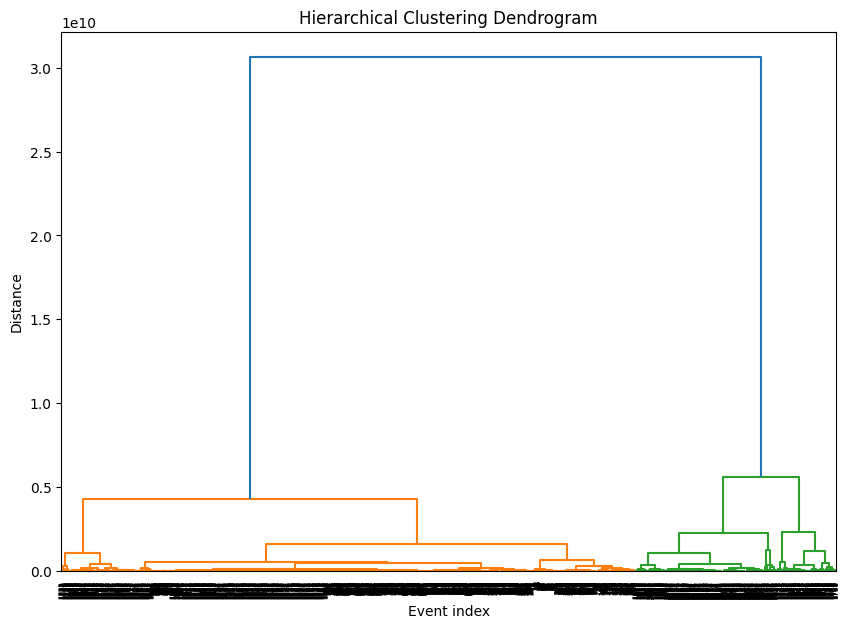

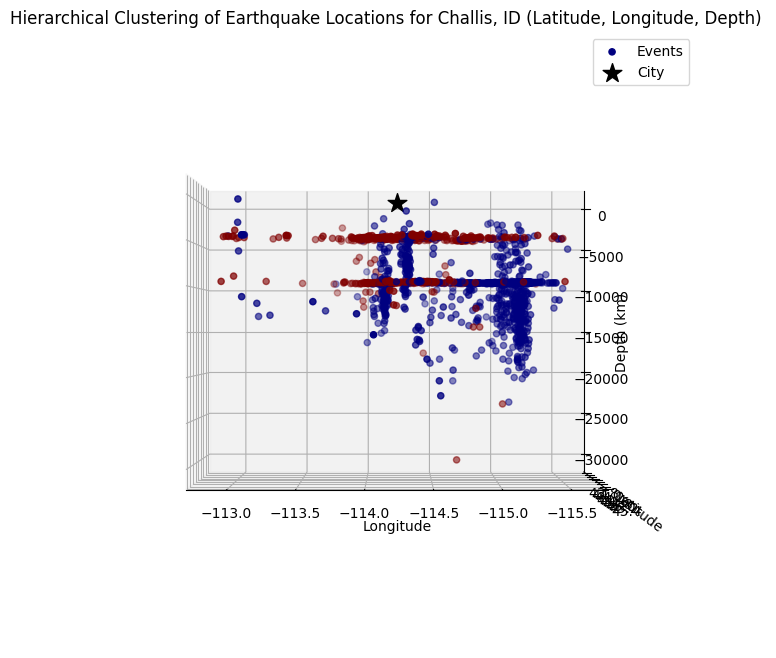

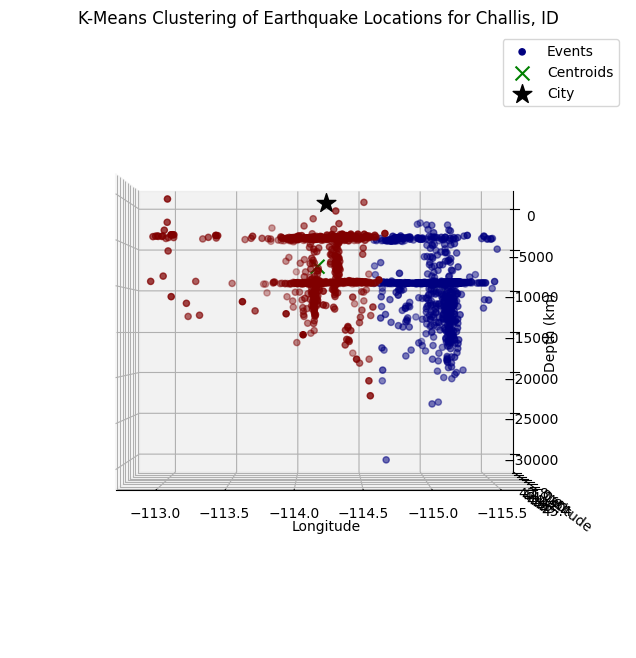

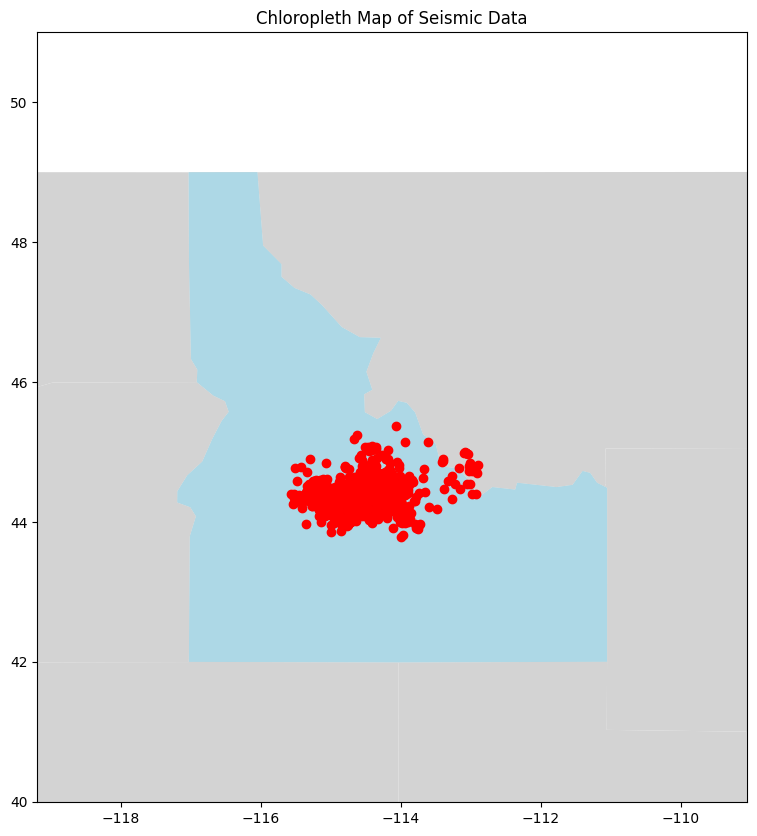

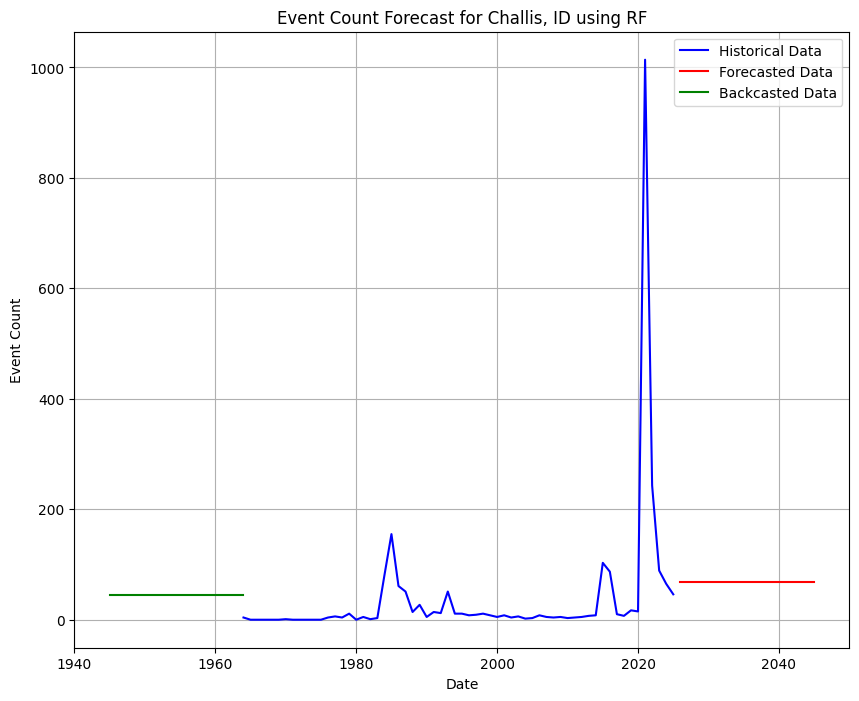


Predicted Number of Events for Challis, ID in the prior 20 YEs:
1944-12-31    45.42
1945-12-31    45.42
1946-12-31    45.42
1947-12-31    45.42
1948-12-31    45.42
1949-12-31    45.42
1950-12-31    45.42
1951-12-31    45.42
1952-12-31    45.42
1953-12-31    45.42
1954-12-31    45.42
1955-12-31    45.42
1956-12-31    45.42
1957-12-31    45.42
1958-12-31    45.42
1959-12-31    45.42
1960-12-31    45.42
1961-12-31    45.42
1962-12-31    45.42
1963-12-31    45.42
Predicted Number of Events for Challis, ID in the next 20 YEs:
2025-12-31    68.68
2026-12-31    68.68
2027-12-31    68.68
2028-12-31    68.68
2029-12-31    68.68
2030-12-31    68.68
2031-12-31    68.68
2032-12-31    68.68
2033-12-31    68.68
2034-12-31    68.68
2035-12-31    68.68
2036-12-31    68.68
2037-12-31    68.68
2038-12-31    68.68
2039-12-31    68.68
2040-12-31    68.68
2041-12-31    68.68
2042-12-31    68.68
2043-12-31    68.68
2044-12-31    68.68


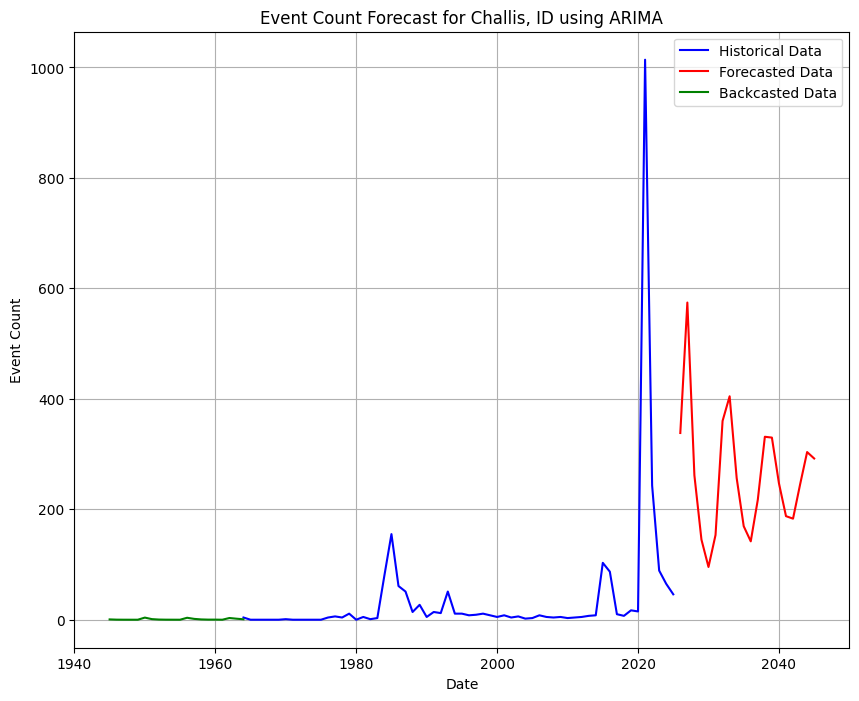


Predicted Number of Events for Challis, ID in the prior 20 YEs:
1944-12-31    0.56
1945-12-31    0.11
1946-12-31    0.02
1947-12-31    0.00
1948-12-31    0.00
1949-12-31    3.84
1950-12-31    1.08
1951-12-31    0.30
1952-12-31    0.08
1953-12-31    0.03
1954-12-31    0.00
1955-12-31    3.53
1956-12-31    1.52
1957-12-31    0.53
1958-12-31    0.17
1959-12-31    0.18
1960-12-31    0.00
1961-12-31    3.09
1962-12-31    1.86
1963-12-31    0.79
Predicted Number of Events Challis, ID for the next 20 YEs:
2025-12-31    338.099911
2026-12-31    574.312922
2027-12-31    261.560299
2028-12-31    145.067096
2029-12-31     95.516290
2030-12-31    153.426923
2031-12-31    359.909558
2032-12-31    404.621063
2033-12-31    256.560341
2034-12-31    169.339007
2035-12-31    141.912509
2036-12-31    217.379259
2037-12-31    331.283680
2038-12-31    329.783142
2039-12-31    247.120560
2040-12-31    187.546260
2041-12-31    183.006338
2042-12-31    244.793019
2043-12-31    303.599900
2044-12-31    291.93

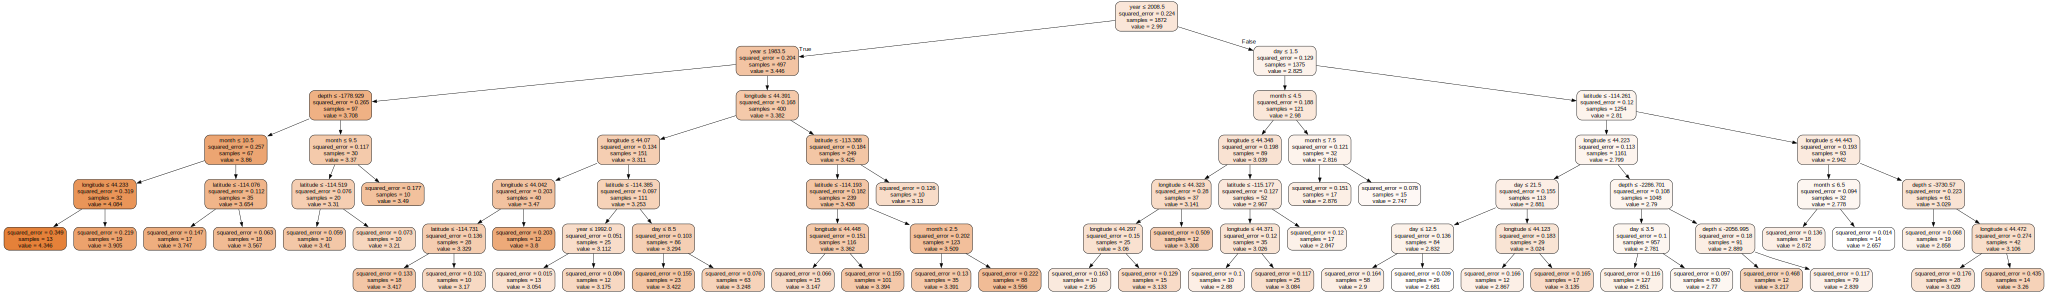

In [4]:
def main():
    """Main function to perform earthquake analysis. Edit variables as need to run code."""
    city = "Challis, ID"
    maxradius = 1
    data_starttime="1900-10-01"                       
    data_endtime="2024-10-11"
    freq='YE'
    elev=0
    azim=90
    clusters=0
    state_name="Idaho"
    country_name="aaaa"
    max_tree_depth=6
    min_samples_leaf=10

    perform_Seismitc_Analysis(city=city, maxradius=maxradius, data_starttime=data_starttime, 
                              data_endtime=data_endtime, freq=freq,  elev=elev, azim=azim,clusters=clusters, 
                              state_name=state_name, country_name=country_name, max_tree_depth=max_tree_depth,
                               min_samples_leaf=min_samples_leaf)

if __name__ == "__main__":
    main()